In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/My\ Drive/Colab\ Notebooks/files/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/files


In [70]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

!pip3 install tensorflow -qqq
!pip3 install wandb -qqq
import wandb
!wandb login
from wandb.keras import WandbCallback

wandb: Currently logged in as: cs6910krsrd (use `wandb login --relogin` to force relogin)


In [71]:
PROJECT_NAME = "CS6910 ASSIGNMENT 2"
cls={'Amphibia':0,
     'Animalia':1,
     'Arachnida':2,
     'Aves':3,
     'Fungi':4,
     'Insecta':5,
     'Mammalia':6,
     'Mollusca':7,
     'Plantae':8,
     'Reptilia':9}

In [72]:
from tensorflow.keras.preprocessing import image

run = wandb.init(project=PROJECT_NAME, job_type="inference")
# use the latest version of the model
model_at = run.use_artifact('cs6910krsrd/CS6910 ASSIGNMENT 2/CNN:v8', type='model')
# rohithd/uncategorized/CNN:v0', type='model'
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model = tf.keras.models.load_model(model_dir)



model:  ./artifacts/CNN:v8


In [73]:

test_data_at = run.use_artifact('krsrinivas/CS6910 ASSIGNMENT 2/test_raw_data_2000:v0', type='raw_data')
test_dir = test_data_at.download()


wandb: Downloading large artifact test_raw_data_2000:v0, 604.34MB. 2000 files... Done. 0:0:0


In [ ]:

imgs = []
true_pred=[]
class_labels = os.listdir(test_dir)
for l in class_labels:
  if l.startswith("."):
    continue
  imgs_per_class = os.listdir(os.path.join(test_dir, l))
  for img in imgs_per_class:
    img_path = os.path.join(test_dir, l, img)
    if img_path[-4:]!=".jpg":
      continue
    img = image.load_img(img_path, target_size=(229, 229))
    img = image.img_to_array(img)
    # don't forget to rescale test images to match the range of inputs
    # to the network
    img = np.expand_dims(img/255.0, axis=0)
    imgs.append(img)
    true_pred.append(cls[l])
imgs = np.vstack(imgs)

In [31]:

preds = {}
classes = model.predict(imgs, batch_size=32)
for c in classes:
  class_id = np.argmax(c)
  if class_id in preds:
    preds[class_id] += 1
  else:
    preds[class_id] = 1

# print the counts of predicted labels as a quick sanity check
# note that for tiny/medium datasets, this won't be very meaningful
print(preds)
run.finish()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
{1: 174, 5: 130, 3: 152, 9: 314, 8: 250, 6: 288, 2: 198, 4: 313, 0: 117, 7: 64}


In [ ]:
run.finish()

In [8]:
model.save('bestmodel.h5')


In [7]:
true_pred_vector=np.zeros((np.shape(true_pred)[0],10))
for i,true_val in enumerate(true_pred):
  true_pred_vector[i,true_val]=1
true_pred_vector=np.array(true_pred_vector)

In [32]:
model.evaluate(imgs,true_pred_vector)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - 27s 426ms/step - loss: 1.7113 - accuracy: 0.4065


[1.711300015449524, 0.4065000116825104]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


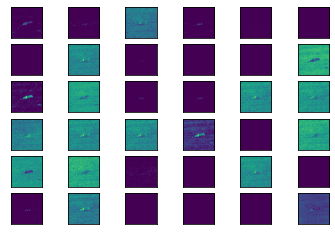

In [9]:
from numpy import random
from keras.models import Model

modelConv1=Model(inputs=model.inputs, outputs=model.layers[0].output)

# take a random image "img"
img= np.expand_dims(imgs[random.randint(0,2000)], axis=0)

preds=modelConv1.predict(img,batch_size=32)
square = 6
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(preds[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
plt.show()

In [59]:
layer_name="conv2d_4"

layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.compat.v1.get_default_graph().gradient_override_map({'Relu': 'GuidedRelu'}):
      with tf.GradientTape() as tape:
          tape.watch(img)
          loss = compute_loss(img, filter_index)
      # Compute gradients.
      grads = tape.gradient(loss, img)
      
    return loss, grads

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img) * 0.25

def visualize_filter(filter_index,img):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    loss=0
    img=np.expand_dims(img, axis=0)
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [47]:
import keras
from IPython.display import Image, display


In [69]:
@tf.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
   gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0
   gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0
   return gate_f * gate_R * grad

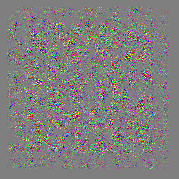

In [68]:

img_width,img_height=229,229

loss, img = visualize_filter(33,imgs[90])
keras.preprocessing.image.save_img("0.png", img)
display(Image("0.png"))


In [64]:
print(imgs[0])

[[[0.5686275  0.5529412  0.3019608 ]
  [0.5137255  0.5568628  0.32941177]
  [0.35686275 0.5176471  0.34509805]
  ...
  [0.8039216  0.76862746 0.64705884]
  [0.75686276 0.7372549  0.62352943]
  [0.74509805 0.7294118  0.6156863 ]]

 [[0.6039216  0.5686275  0.27450982]
  [0.5921569  0.5686275  0.3254902 ]
  [0.2509804  0.45490196 0.26666668]
  ...
  [0.7921569  0.76862746 0.63529414]
  [0.7647059  0.7529412  0.6313726 ]
  [0.7372549  0.7372549  0.627451  ]]

 [[0.6117647  0.58431375 0.36862746]
  [0.62352943 0.5921569  0.30588236]
  [0.29411766 0.44313726 0.21176471]
  ...
  [0.78431374 0.75686276 0.6431373 ]
  [0.74509805 0.7411765  0.6313726 ]
  [0.70980394 0.7176471  0.62352943]]

 ...

 [[0.65882355 0.68235296 0.6431373 ]
  [0.7137255  0.7607843  0.7058824 ]
  [0.7254902  0.7764706  0.7372549 ]
  ...
  [0.6509804  0.7058824  0.6156863 ]
  [0.34901962 0.4627451  0.4862745 ]
  [0.32941177 0.5372549  0.69411767]]

 [[0.69803923 0.69803923 0.6901961 ]
  [0.6745098  0.7058824  0.64705884]


In [ ]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient('GuidedBackProp')
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)


def modify_backprop(model, name):
    new_model=tf.keras.models.clone_model(
    model, input_tensors=None, clone_function=None
)
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu
    return new_model


def guided_backpropagation(img_tensor, model, activation_layer):
    model_input = model.input
    layer_output = model.get_layer(activation_layer).output

    max_output = K.max(layer_output, axis=3)

    get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
    saliency = get_output([img_tensor])

    return saliency[0]

In [ ]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.1

    # Center crop
    #img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 229, 229, 36)      144       
_________________________________________________________________
batch_normalization (BatchNo (None, 229, 229, 36)      144       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 114, 114, 36)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 49)      7105      
_________________________________________________________________
batch_normalization_1 (Batch (None, 113, 113, 49)      196       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 49)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        3

In [ ]:
img_width, img_height=229,229

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')


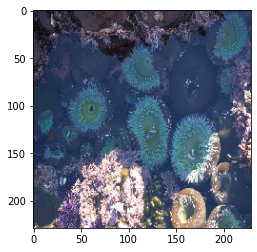

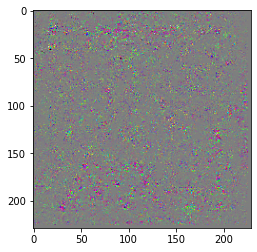

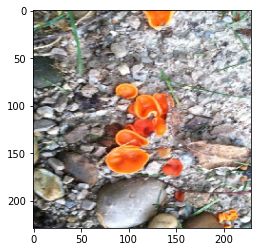

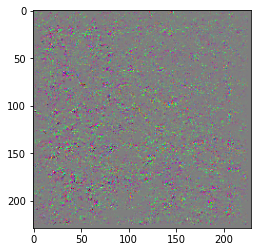

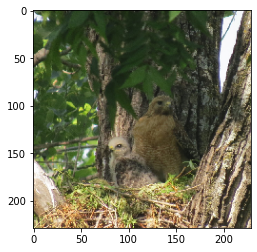

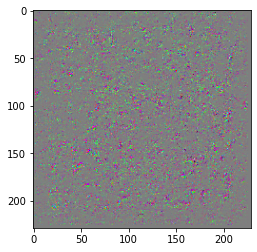

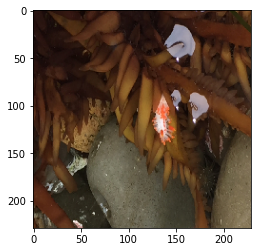

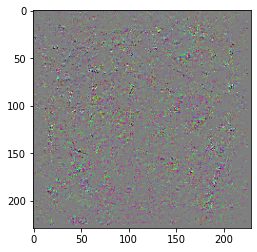

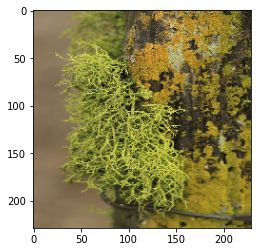

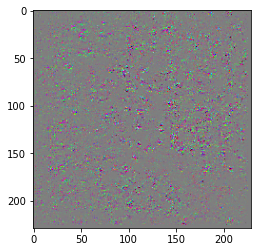

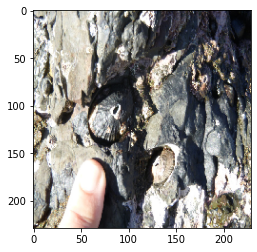

KeyboardInterrupt: ignored

In [ ]:


#guided_model = modify_backprop(model, 'GuidedBackProp')
for i in range(50):
  img=imgs[np.random.randint(0,2000)]
  img= np.expand_dims(img, axis=0)
  plt.imshow(img[0])
  plt.show()
  gradient = guided_backpropagation(img, model, "conv2d_4")
  plt.imshow(deprocess_image(gradient)[0])
  plt.show()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


predicted top1 class: 644
Predicted: [('n03729826', 'matchstick', 0.0764374)]


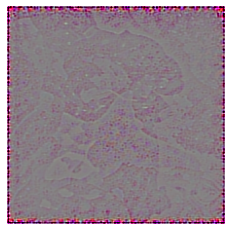

In [ ]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K

import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np
import matplotlib.pyplot as plt
!pip install utils
#from utils import deprocess_image


def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x


def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)


def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model


def guided_backpropagation(img_tensor, model, activation_layer):
    model_input = model.input
    layer_output = model.get_layer(activation_layer).output

    max_output = K.max(layer_output, axis=3)

    get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
    saliency = get_output([img_tensor])

    return saliency[0]


if __name__ == "__main__":
    img_width = 224
    img_height = 224

    model = VGG16(weights='imagenet')
    print(model.summary())

    img=imgs[np.random.randint(0,2000)][:224,:224]
    img= np.expand_dims(img, axis=0)
    img = preprocess_input(img)


    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print("predicted top1 class:", predicted_class)
    print('Predicted:', decode_predictions(preds, top=1)[0])
    # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]


    register_gradient()
    guided_model = modify_backprop(model, 'GuidedBackProp')
    gradient = guided_backpropagation(img, guided_model, "block5_conv3")

    plt.figure(0)
    plt.imshow(deprocess_image(gradient)[0])
    plt.axis('off')
    plt.show()

Model prediction:


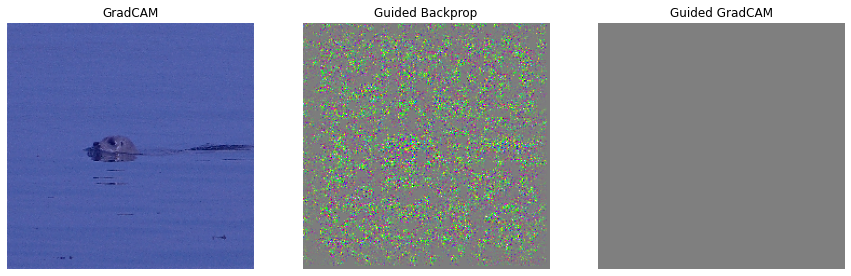

In [ ]:
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras import backend as K
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.python.framework import ops

# Define model here ---------------------------------------------------
def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    return model

H, W = 229, 229 # Input shape, defined by the model (model.input_shape)
# ---------------------------------------------------------------------

def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x=x/255.0
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val


def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0: 
        cam = cam / cam_max
    return cam
    
def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], W, H))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (H, W), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams


def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 5
    #top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    #for c, p in zip(classes, top):
#print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    #if cls == -1:
     #   cls = np.argmax(predictions)
    #class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    #print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

if __name__ == '__main__':

    guided_model = build_guided_model()
    gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, layer_name='conv2d_4',
                                             img_path=sc, cls=-1, visualize=True, save=True)

# New Section

In [ ]:
sc=test_dir+"/Amphibia/001e540d0d11ed1188a5cbe4174c5c69.jpg"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


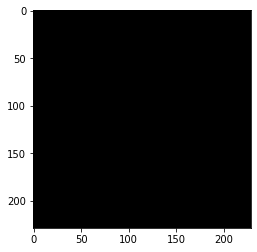

In [ ]:
plt.imshow(load_image(sc, preprocess=True)[0])

In [ ]:
sc="./artifacts/test_raw_data_2000:v0/Mammalia/024c92a96de7c1df3d33fdfa86dd9f1a.jpg"

In [ ]:
tf.compat.v1.disable_eager_execution()


In [ ]:
img_path

'./artifacts/test_raw_data_2000:v0/Aves/eea551e40f43302ecd274bd7ba0bf41a.jpg'

In [ ]:
x = image.load_img(sc, target_size=(H, W))

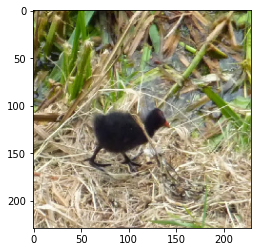

In [ ]:
plt.imshow(x)